In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.biases = [np.zeros((1, layers[i+1])) for i in range(len(layers)-1)]
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward_pass(self, X):
        activations = [X]
        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            activations.append(self.sigmoid(z))
        return activations
    
    def backward_pass(self, X, Y, activations):
        deltas = [(activations[-1] - Y) * self.sigmoid_derivative(activations[-1])]
        for i in range(len(self.layers) - 2, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.sigmoid_derivative(activations[i])
            deltas.insert(0, delta)
        return deltas
    
    
    def compute_gradients(self, activations, deltas):
        gradients_weights = [np.dot(activations[i].T, deltas[i]) for i in range(len(self.layers) - 1)]
        gradients_biases = [np.sum(deltas[i], axis=0) for i in range(len(self.layers) - 1)]
        return gradients_weights, gradients_biases
    
    def update_weights(self, gradients_weights, gradients_biases, learning_rate):
        self.weights = [w - learning_rate * gw for w, gw in zip(self.weights, gradients_weights)]
        self.biases = [b - learning_rate * gb for b, gb in zip(self.biases, gradients_biases)]
    
    def train(self, X, Y, learning_rate, lam, max_iterations, epsilon):
        for iteration in range(max_iterations):
            activations = self.forward_pass(X)
            deltas = self.backward_pass(X, Y, activations)
            gradients_weights, gradients_biases = self.compute_gradients(activations, deltas)
            self.update_weights(gradients_weights, gradients_biases, learning_rate)
            # Compute cost function
            J = np.mean(np.square(activations[-1] - Y))
            #print(f"Iteration {iteration+1}, Cost: {J}")
            # Check for convergence
            if J < epsilon:
                #print(f"Converged at cost :{J} while Epsilon:{epsilon} ")
                return J
        return J
            

    def accuracy(self, y_true, y_pred):
        correct = np.sum(np.all(y_true == y_pred, axis=1))
        return correct / len(y_true)


    def f1_score(self, y_true, y_pred):
        tp = np.sum(np.logical_and(y_true, y_pred))
        fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
        fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        return f1


    def evaluate(self, X_test, y_test, J):
        activations = self.forward_pass(X_test)[-1]
        y_pred = (activations > 0.5).astype(int)
        acc = self.accuracy(y_test, y_pred)
        f1 = self.f1_score(y_test, y_pred)
        return J, acc, f1
    
    def k_fold_cross_validation(X, y, architectures, regularization_params, learning_rate, max_iterations, epsilon):
        results_accuracy = {}
        results_f1_score = {}
        results_J_cost = {}
        
        num_splits = 10
        fold_size = len(X) // num_splits

        for arch in architectures:
            for lam in regularization_params:
                accuracy_list = []
                f1_score_list = []
                J_list = []
                
                for i in range(num_splits):
                    start = i * fold_size
                    end = (i + 1) * fold_size
                    
                    X_train = pd.concat([X[:start], X[end:]])
                    y_train = np.concatenate([y[:start], y[end:]])
                    X_test = X[start:end]
                    y_test = y[start:end]

                    mean = np.mean(X_train, axis=0)
                    std = np.std(X_train, axis=0)
                    X_train_normalized = (X_train - mean) / std
                    X_test_normalized = (X_test - mean) / std

                    model = NeuralNetwork(arch)
                    J = model.train(X_train_normalized, y_train, learning_rate=learning_rate, lam=lam, max_iterations=max_iterations, epsilon=epsilon)
                    J, accuracy, f1_score = model.evaluate(X_test_normalized, y_test, J)
                    accuracy_list.append(accuracy)
                    f1_score_list.append(f1_score)
                    J_list.append(J)

                mean_accuracy = np.mean(accuracy_list)
                mean_f1_score = np.mean(f1_score_list)
                mean_J_cost   = np.mean(J_list)

                results_accuracy[(str(arch), lam)] = mean_accuracy
                results_f1_score[(str(arch), lam)] = mean_f1_score
                results_J_cost[(str(arch), lam)] = mean_J_cost

        return results_accuracy, results_f1_score, results_J_cost


# Load dataset
df_cancer = pd.read_csv("/Users/noshitha/Downloads/hw4/datasets/hw3_cancer.csv", delimiter="\t")

# Extract features and target variable
X_cancer = pd.get_dummies(df_cancer.drop(columns=['Class']))  # Features
y_cancer = df_cancer['Class']  


# Re-size data
y_cancer_resized = y_cancer.values.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the target variable
y_encoded = encoder.fit_transform(y_cancer_resized)

# Define model architectures and regularization parameters
architectures = [
    [X_cancer.shape[1], 5, y_encoded.shape[1]] , 
    [X_cancer.shape[1], 6, 4, y_encoded.shape[1]],  
    [X_cancer.shape[1],7, 5, 3, y_encoded.shape[1]],  
    [X_cancer.shape[1], 8, 6, 4, 3, y_encoded.shape[1]], 
    [X_cancer.shape[1],1,2,2,2,2,2,2,2,2,2, y_encoded.shape[1]], 
    [X_cancer.shape[1], 20, y_encoded.shape[1]]  
]

regularization_params = [0.01, 0.1, 1.0]  # Example regularization parameters

# Initialize lists to store results
results_accuracy = {}
results_f1_score = {}
results_J_cost = {}
# Perform stratified k-fold cross-validation
results_accuracy, results_f1_score, results_J_cost = NeuralNetwork.k_fold_cross_validation(X_cancer, y_encoded, architectures, regularization_params, learning_rate=0.01, max_iterations=1000, epsilon=0.005)

# Convert the results into a DataFrame for tabular representation
accuracy_df = pd.DataFrame(list(results_accuracy.items()), columns=['Architecture, Lambda', 'Mean Accuracy'])
f1_score_df = pd.DataFrame(list(results_f1_score.items()), columns=['Architecture, Lambda', 'Mean F1 Score'])
J_cost_df = pd.DataFrame(list(results_J_cost.items()), columns=['Architecture, Lambda', 'Mean J Cost'])

print("Mean Accuracy Results:")
print(accuracy_df)
print("\nMean F1 Score Results:")
print(f1_score_df)
print("\nMean J cost Results:")
print(J_cost_df)

Mean Accuracy Results:
                            Architecture, Lambda  Mean Accuracy
0                              ([9, 5, 2], 0.01)       0.950725
1                               ([9, 5, 2], 0.1)       0.959420
2                               ([9, 5, 2], 1.0)       0.955072
3                           ([9, 6, 4, 2], 0.01)       0.947826
4                            ([9, 6, 4, 2], 0.1)       0.953623
5                            ([9, 6, 4, 2], 1.0)       0.955072
6                        ([9, 7, 5, 3, 2], 0.01)       0.946377
7                         ([9, 7, 5, 3, 2], 0.1)       0.950725
8                         ([9, 7, 5, 3, 2], 1.0)       0.950725
9                     ([9, 8, 6, 4, 3, 2], 0.01)       0.962319
10                     ([9, 8, 6, 4, 3, 2], 0.1)       0.952174
11                     ([9, 8, 6, 4, 3, 2], 1.0)       0.946377
12  ([9, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 0.01)       0.656522
13   ([9, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 0.1)       0.656522
14   ([9, 1, 2, 2

In [4]:
# Merge accuracy and f1_score DataFrames on 'Architecture, Lambda'
merged_df = pd.merge(accuracy_df, f1_score_df, on='Architecture, Lambda')

# Merge the merged DataFrame with J_cost_df on 'Architecture, Lambda'
final_df = pd.merge(merged_df, J_cost_df, on='Architecture, Lambda')

# Rename columns for clarity
merged_df.columns = ['Architecture, Lambda', 'Mean Accuracy', 'Mean F1 Score']
merged_df

,"Architecture, Lambda",Mean Accuracy,Mean F1 Score
0,"([9, 5, 2], 0.01)",0.950725,0.952174
1,"([9, 5, 2], 0.1)",0.959420,0.960161
2,"([9, 5, 2], 1.0)",0.955072,0.956584
3,"([9, 6, 4, 2], 0.01)",0.947826,0.949170
4,"([9, 6, 4, 2], 0.1)",0.953623,0.954374
5,"([9, 6, 4, 2], 1.0)",0.955072,0.955875
6,"([9, 7, 5, 3, 2], 0.01)",0.946377,0.946377
7,"([9, 7, 5, 3, 2], 0.1)",0.950725,0.950725
8,"([9, 7, 5, 3, 2], 1.0)",0.950725,0.951475
9,"([9, 8, 6, 4, 3, 2], 0.01)",0.962319,0.962319


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate mini-batches
def generate_mini_batches(X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []
    shuffled_indices = np.random.permutation(num_samples)
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        mini_batches.append((X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]))
    if num_samples % batch_size != 0:
        mini_batches.append((X_shuffled[num_batches*batch_size:], y_shuffled[num_batches*batch_size:]))
    return mini_batches

def manual_train_test_split(X, y, test_size=0.2):
    indices = np.random.permutation(X.shape[0])
    test_indices = indices[:int(test_size * X.shape[0])]
    train_indices = indices[int(test_size * X.shape[0]):]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

def train_mini_batch(X_train, y_train, X_test, y_test, model, learning_rate, batch_size, max_iterations, epsilon):
    training_errors = []
    testing_errors = []
    for iteration in range(max_iterations):
        mini_batches = generate_mini_batches(X_train, y_train, batch_size)
        for mini_batch in mini_batches:
            X_mini_batch, y_mini_batch = mini_batch
            J = model.train(X_mini_batch, y_mini_batch, learning_rate=learning_rate, lam=0.001, max_iterations=1, epsilon=epsilon)
        training_cost = np.mean(np.square(model.forward_pass(X_train)[-1] - y_train))  # Compute training cost
        testing_cost = np.mean(np.square(model.forward_pass(X_test)[-1] - y_test))  # Compute testing cost
        training_errors.append(training_cost)
        testing_errors.append(testing_cost)
        print(f"Iteration {iteration+1}, Training Cost: {training_cost}, Testing Cost: {testing_cost}")
        # Check for convergence
        if training_cost < epsilon:
            #print(f"Converged at training cost :{training_cost} while Epsilon:{epsilon} ")
            break
    return training_errors, testing_errors

# Plot learning curve
def plot_learning_curve(training_errors, testing_errors, step_size):
    iterations = range(1, len(training_errors) + 1)
    plt.plot(iterations, training_errors, label='Training Error')
    plt.plot(iterations, testing_errors, label='Testing Error')
    plt.title('Learning Curve')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('J values')
    plt.xticks(np.arange(1, len(training_errors) + 1, step=step_size))
    plt.legend()
    plt.grid(True)
    plt.show()
    


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define your neural network model and parameters
model = NeuralNetwork([X_cancer.shape[1], 5, y_encoded.shape[1]])  # Your desired architecture
learning_rate = 0.01
batch_size = 32
max_iterations = 1000
epsilon = 0.005

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_encoded, test_size=0.2)

# Standardize features
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

# Train the model using mini-batch gradient descent
training_errors, testing_errors = train_mini_batch(X_train_normalized.to_numpy(), y_train, X_test_normalized.to_numpy(), y_test, model, learning_rate, batch_size, max_iterations, epsilon)

Iteration 1, Training Cost: 0.2752389140520499, Testing Cost: 0.27552875711963665
Iteration 2, Training Cost: 0.18556871232435868, Testing Cost: 0.18481552810857205
Iteration 3, Training Cost: 0.15824526507486647, Testing Cost: 0.15708772521175685
Iteration 4, Training Cost: 0.14027958173004298, Testing Cost: 0.13974485604398926
Iteration 5, Training Cost: 0.12457676231233172, Testing Cost: 0.1252184060497719
Iteration 6, Training Cost: 0.11014663990640974, Testing Cost: 0.11196150284540905
Iteration 7, Training Cost: 0.09723147524780275, Testing Cost: 0.10015256253491203
Iteration 8, Training Cost: 0.08599109454974233, Testing Cost: 0.0896937612499988
Iteration 9, Training Cost: 0.07651720441537353, Testing Cost: 0.08088659184182058
Iteration 10, Training Cost: 0.06869023696168922, Testing Cost: 0.07356160749303065
Iteration 11, Training Cost: 0.06223864816543884, Testing Cost: 0.06758363663329288
Iteration 12, Training Cost: 0.057022231027541684, Testing Cost: 0.06267654557268675
Ite

Iteration 140, Training Cost: 0.023996353740462707, Testing Cost: 0.03468381563176268
Iteration 141, Training Cost: 0.023984302051123684, Testing Cost: 0.03469979448744668
Iteration 142, Training Cost: 0.02397230907987636, Testing Cost: 0.03471299425907947
Iteration 143, Training Cost: 0.02396044272771331, Testing Cost: 0.03472523177290365
Iteration 144, Training Cost: 0.02394873876490882, Testing Cost: 0.03474005531655352
Iteration 145, Training Cost: 0.02393712906098366, Testing Cost: 0.03475332783381036
Iteration 146, Training Cost: 0.02392566984816799, Testing Cost: 0.03476591942065356
Iteration 147, Training Cost: 0.023914329393801594, Testing Cost: 0.03477993127724836
Iteration 148, Training Cost: 0.023903089000304585, Testing Cost: 0.03479258381573211
Iteration 149, Training Cost: 0.0238919375591713, Testing Cost: 0.03480456060391753
Iteration 150, Training Cost: 0.023880927749342327, Testing Cost: 0.03481772860836108
Iteration 151, Training Cost: 0.023870006436920346, Testing C

Iteration 291, Training Cost: 0.02282259845171054, Testing Cost: 0.03730607051182948
Iteration 292, Training Cost: 0.022816239947185638, Testing Cost: 0.037327704028706964
Iteration 293, Training Cost: 0.02280987359351212, Testing Cost: 0.03734870782038591
Iteration 294, Training Cost: 0.02280350452912171, Testing Cost: 0.03737166024565443
Iteration 295, Training Cost: 0.022797167174250902, Testing Cost: 0.037395008573549306
Iteration 296, Training Cost: 0.02279078565817117, Testing Cost: 0.037418199766962146
Iteration 297, Training Cost: 0.02278440465875423, Testing Cost: 0.03743949548388445
Iteration 298, Training Cost: 0.022778057877608743, Testing Cost: 0.037461013165329037
Iteration 299, Training Cost: 0.02277170257746406, Testing Cost: 0.03748212705942996
Iteration 300, Training Cost: 0.022765349942801046, Testing Cost: 0.0375045958125206
Iteration 301, Training Cost: 0.02275898520319203, Testing Cost: 0.03752762533251481
Iteration 302, Training Cost: 0.022752608223834486, Testin

Iteration 443, Training Cost: 0.0218452224428906, Testing Cost: 0.04075694323235038
Iteration 444, Training Cost: 0.0218393363065593, Testing Cost: 0.04077788734914958
Iteration 445, Training Cost: 0.02183348682352908, Testing Cost: 0.0407966216159941
Iteration 446, Training Cost: 0.021827638845108115, Testing Cost: 0.040814898390698975
Iteration 447, Training Cost: 0.021821816224717766, Testing Cost: 0.040835238457712066
Iteration 448, Training Cost: 0.021816007076154692, Testing Cost: 0.04085538858955362
Iteration 449, Training Cost: 0.021810253199730213, Testing Cost: 0.04087682174339121
Iteration 450, Training Cost: 0.021804508120822984, Testing Cost: 0.04089831286093782
Iteration 451, Training Cost: 0.02179878460463657, Testing Cost: 0.040920419232824884
Iteration 452, Training Cost: 0.021793062384353398, Testing Cost: 0.04094091410761861
Iteration 453, Training Cost: 0.021787377698816824, Testing Cost: 0.040961854176238495
Iteration 454, Training Cost: 0.02178167663616268, Testin

Iteration 594, Training Cost: 0.021153508990000354, Testing Cost: 0.042967715539125054
Iteration 595, Training Cost: 0.021149941671621538, Testing Cost: 0.042978242303937035
Iteration 596, Training Cost: 0.021146367497459066, Testing Cost: 0.04298629567545874
Iteration 597, Training Cost: 0.021142806080102616, Testing Cost: 0.04299578227208052
Iteration 598, Training Cost: 0.021139252247290723, Testing Cost: 0.04300482001919796
Iteration 599, Training Cost: 0.021135701046056395, Testing Cost: 0.04301187442116718
Iteration 600, Training Cost: 0.02113217460448031, Testing Cost: 0.043021342703579796
Iteration 601, Training Cost: 0.02112864476637149, Testing Cost: 0.043031009472133716
Iteration 602, Training Cost: 0.02112512792119691, Testing Cost: 0.04303863992844975
Iteration 603, Training Cost: 0.021121628080515736, Testing Cost: 0.04304599598539644
Iteration 604, Training Cost: 0.021118131699256852, Testing Cost: 0.04305397963268526
Iteration 605, Training Cost: 0.021114657421105954, T

Iteration 740, Training Cost: 0.020709985552130074, Testing Cost: 0.04396352376463123
Iteration 741, Training Cost: 0.02070737510129659, Testing Cost: 0.04396741041195921
Iteration 742, Training Cost: 0.020704785167623207, Testing Cost: 0.043973060451173225
Iteration 743, Training Cost: 0.020702192336588203, Testing Cost: 0.0439765332936962
Iteration 744, Training Cost: 0.02069960418120966, Testing Cost: 0.04398166661433204
Iteration 745, Training Cost: 0.020697020319433195, Testing Cost: 0.04398534035631107
Iteration 746, Training Cost: 0.02069443330010549, Testing Cost: 0.04398955328266629
Iteration 747, Training Cost: 0.02069185842977657, Testing Cost: 0.043993379386949194
Iteration 748, Training Cost: 0.0206892933121496, Testing Cost: 0.04399772260510863
Iteration 749, Training Cost: 0.02068673447798039, Testing Cost: 0.04400318542922194
Iteration 750, Training Cost: 0.020684174862103666, Testing Cost: 0.04400730098934732
Iteration 751, Training Cost: 0.0206816168382047, Testing Co

Iteration 893, Training Cost: 0.02035555829108953, Testing Cost: 0.04454289461528431
Iteration 894, Training Cost: 0.020353470196306168, Testing Cost: 0.04454517402394304
Iteration 895, Training Cost: 0.02035138271186503, Testing Cost: 0.044548193796868224
Iteration 896, Training Cost: 0.02034930586978429, Testing Cost: 0.0445502097483741
Iteration 897, Training Cost: 0.020347199720730774, Testing Cost: 0.04455546883528268
Iteration 898, Training Cost: 0.0203451165847934, Testing Cost: 0.04455781638577293
Iteration 899, Training Cost: 0.02034303167195172, Testing Cost: 0.04456092179173648
Iteration 900, Training Cost: 0.020340958380403843, Testing Cost: 0.04456332347281259
Iteration 901, Training Cost: 0.020338883281119033, Testing Cost: 0.0445658055127395
Iteration 902, Training Cost: 0.02033681281983375, Testing Cost: 0.04456854914464297
Iteration 903, Training Cost: 0.02033473385604263, Testing Cost: 0.04457142132528831
Iteration 904, Training Cost: 0.020332665503889836, Testing Cos

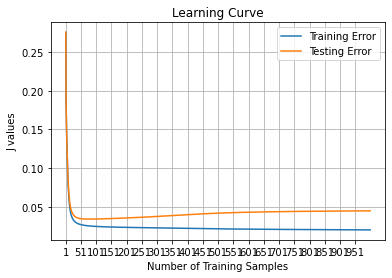

In [15]:
# Plot the learning curve
step_size = 50
plot_learning_curve(training_errors, testing_errors, step_size)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to generate mini-batches
def generate_mini_batches(X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []
    shuffled_indices = np.random.permutation(num_samples)
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        mini_batches.append((X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]))
    if num_samples % batch_size != 0:
        mini_batches.append((X_shuffled[num_batches*batch_size:], y_shuffled[num_batches*batch_size:]))
    return mini_batches


def train_mini_batch(X_train, y_train, X_test, y_test, model, learning_rate, batch_size, max_iterations, epsilon):
    training_errors = []
    testing_errors = []
    for iteration in range(max_iterations):
        mini_batches = generate_mini_batches(X_train, y_train, batch_size)
        for mini_batch in mini_batches:
            X_mini_batch, y_mini_batch = mini_batch
            J = model.train(X_mini_batch, y_mini_batch, learning_rate=learning_rate, lam=lam, max_iterations=1, epsilon=epsilon)
        training_cost = np.mean(np.square(model.forward_pass(X_train)[-1] - y_train))  # Compute training cost
        testing_cost = np.mean(np.square(model.forward_pass(X_test)[-1] - y_test))  # Compute testing cost
        training_errors.append(training_cost)
        testing_errors.append(testing_cost)
        print(f"Iteration {iteration+1}, Training Cost: {training_cost}, Testing Cost: {testing_cost}")
        # Check for convergence
        if training_cost < epsilon:
            print(f"Converged at training cost :{training_cost} while Epsilon:{epsilon} ")
            break
    return training_errors, testing_errors

# Plot learning curve
def plot_learning_curve(training_errors, testing_errors, step_size):
    iterations = range(1, len(training_errors) + 1)
    plt.plot(iterations, training_errors, label='Training Error')
    plt.plot(iterations, testing_errors, label='Testing Error')
    plt.title('Learning Curve')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Error (J)')
    plt.xticks(np.arange(1, len(training_errors) + 1, step=step_size))
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define your neural network model and parameters
model = NeuralNetwork([X_house_votes.shape[1], 10, 8, y_encoded.shape[1]])  # Your desired architecture
learning_rate = 0.01
batch_size = 32
max_iterations = 1000
epsilon = 0.005

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_house_votes, y_encoded, test_size=0.2, random_state=42)

# Standardize features
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

# Train the model using mini-batch gradient descent
training_errors, testing_errors = train_mini_batch(X_train_normalized, y_train, X_test_normalized, y_test, model, learning_rate, batch_size, max_iterations, epsilon)

KeyError: "None of [Int64Index([127, 164,  45, 311, 300, 279, 196, 108, 198,  92,\n            ...\n            195, 236, 314,  22, 223,  52, 270, 325,  37, 104],\n           dtype='int64', length=348)] are in the [columns]"

In [ ]:
# Plot the learning curve
step_size = 50  # Adjust as needed
plot_learning_curve(training_errors, testing_errors, step_size)